# Political Sentiment analysis with classical Machine Learning algorithms


![title](data/twit_cld.png)

*Cloud representation of the words over 800 comments sample in a Twitter logo form. More about it and how to do it - scroll down to EDA section.*

## Abstract

Sentiment analysis is one of the most popular fields of the Natural Language processing. Ofter referred to as "opinion mining" or "emotional AI" the Sentiment analysis is widely used nowadays because of the raw text data that people generate every day. The rise of the social media usage also plays huge part in sentiment analysis' rising popularity. We do share opinions, we post, comment, tweet in social media, forums and blogs about anything - from political views, to assessment of the product we've just received, the magazine we've subscribed to, the book we've read, the movie we've watched, etc.. this chunk of information in the WWW gives us a lot of opportunities. Imagine how useful and important this feedback could be for the people created these producs. 

In this work we'll go through the entire process of creating a good model for Sentiment analysis - from processing the data, analyzing it with the EDA and at the end, hopefully, to creating a good model with some of the classical Machine Learning algorithms. 

There are many ways to approach this problem but we'll stick to scikit learn. NLTK and Gensim are some great alternatives but we will try to find the best model among as many other machine learning algorithms as possible and scikit-learn's power, simplicity and wide range of integrated, easy to work with algorithms will be the best for the job. Of course we'll explain thoroughly every step along the way.


## Datasets and Pipeline of  this paper

The main focus on this reseach will be to build a model that regognizes the emotions of the people writing tweets about Indian politics. The most common scenario with the Sentiment analysis is our target variable to be 1/positive or 0/negative. This might be extended more to 'neutral', 'strong positive', 'strong negative' etc. In our case we will have classes labelled from -1 to 1 as -1 being negative, 0 being neutral and 1 being positive.

- We'll be using this [twitter dataset](https://www.kaggle.com/cosmos98/twitter-and-reddit-sentimental-analysis-dataset) in attempt to build a nice algorithm that recognizes  unknown comments in the social media and classifies them.


- These tweets and Comments Were Made on Narendra Modi and Other Leaders as well as Peoples Opinion Towards the Next Prime Minister of The Nation ( In Context with General Elections Held In India - 2019). This sort of tweets our model will specialize in.


- It consists of more than  163k comments which is way too many so we will 'only' use half of that here for now.

This project will follow the standard cycle of machine learning project - we will read and preprocess the datasets, we'll get familiar with the data using visualizations, diagrams and matrices, we'll make educated assumptions and finally we'll train the models and hopefully score great results.

## Understanding the problem and set up the goal

Before we dive into the Sentiment Analysis we need to answer few questions. Sentiment analysis as a text problem has unstructured data and it's very hard. We need to deal with sarcasm, topic selection, many different ways of expression including illiteracy etc. For our specific case we also need to keep in mind that the people whose sentiments we are analyzing aren't native English speakers. Giants like Youtube and Twitter are relatively new to India so it's not correct to compare and expect the tweets about Modi and let's say tweets about Trump to look the same and mean the same thing.

Even some people with their experience and understanding of feelings and sarcasm have difficult time to guess whether a tweet or review is positive or negative. So we should not expect our metrics and evaluations techniques to go sky high as we are dealing with structured well defined task. That's first.

Second, we are applying Standard Machine Learning algorithms here. This means we value our time and we value our comprehension of our work. So we need to understand what's going on and why these algorithms do this and the others do that, we need a good balance between performence in terms of metrics but also in terms of training and tuning time. There will be a thorough explanation of our strategy when we start modelling. 

To summarize - we need as simple model as possible, a model that can be explained and understood, a model that is  fast but scores great on testing and validating data. Pretty easy, right?

### Libraries

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
np.random.seed(500)


# These libraries are for better visualizations and graphics. You can skip them easily and stick to plt
# but they are more powerful in terms of interactivity and good looks

from wordcloud import WordCloud
from PIL import Image
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import time
import seaborn as sns


# these are the imports from Scikit Learn and NLTK to perform actual Machine Learning,
# NLP and operations over the text


from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict ,RandomizedSearchCV,StratifiedKFold, GridSearchCV, train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier

from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
import re

[nltk_data] Downloading package wordnet to /home/vlado/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Read and process the data

Nothing unusual here, we use pandas to read the data and get the first 80k observations. We'll train on them for the start and later we will find the best usage of the other half depending on the situation we are in.

In [3]:
data = pd.read_csv('data/Twitter_Data.csv', nrows=80000)
data.columns = ['review', 'sentiment']

In [4]:
data.sample(3)

review  sentiment
30390  bibi and modi are exact same positions both kn...          1
65269  \npart what your todays editorial cartoon sugg...          0
77949    then modi would have released lot gas the space          0

Now that we read the data, we are good to start with the processing. This is the most underrated but probably the most important step in our plan to successfully build a good model for Sentiment analysis. We'll be working with raw text and as we know computers don't understand letters, they need numbers. So we have to be extremely cautious while turning it. 

The source of the dataset claims that it is already processed and ready to work with. It never hurts to make sure yourself you are not letting some garbage in. So we will go full on this part of the work. NLP tasks work with a lot of data and it cannot be manually checked. The matrices are huge and every single garbage, as you will see later, can be turn into information to computer, so it's definitely worth it being extra cautious.

In [5]:
data = data.drop_duplicates()
data = data.dropna()
data = data.reset_index()

Making sure there are no duplicates, neither missing values. There is only one so we can make it without it.
Let's clean the text from some of the specifics of the English language + eventually white spaces, numbers, strange symbols. We'll be using Regular expression. This function basically replace the first parameter with the second.

We apply it to every single observation.



In [6]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r'\d', '', text)
    text = text.strip(' ')
    return text


cleaned_data = [clean_text(x) for x in data['review']]
data['review'] = cleaned_data

In [7]:
data['review'][100][:250]

'why limited here are other prefixes for twitter that perhaps more accurately capture the state the citizens'

We'll keep one example for a comparison in that we'll make in a bit.

## Stemming

You will see either stemming or lemmatizing in almost any NLP taks if done correctly. I already noticed that neither of these have been performed on our data which is a big risk, so we need to decide what to do.

Stemming and lemmatizing are methods that are normalizing our data. Both models will reduce every single word to its simpler, more basic component, but unlike stemming, lemmatizing will return the actual root of the word. Stemming cuts some words and returns non existing words but it's not big deal for the machines anyway. 

I personally enjoy lemmatizing better because its better for analysis, mining and visual representation but for this job I think stemming is better.

First of all, this is Twitter. People are not typing as they would if they were at school or at the office. Second, even tho it's official language in some parts of India we cannot expect 100% literacy for such a large chunk of data. This will slow down lemmatizing a lot. Third, stemming is usually faster and we are talking about big dataset here.

In [8]:
# We will be using SnowballStemmer which is developed from Martin Porter 
# and it's very good and fast for English. It's an optimization of the classical 
# Porter Stemmer named after the same man


def stem_series(series):
    """
    1) We use word_tokenizer from NLTK for each comment which splits by word,
    2) then we apply stemming on each word and add it to 'new_row',
    3) then append the stemmed row to the new list
    4) and at the end we return it
    """
    stemmer = SnowballStemmer(language='english', ignore_stopwords=True)
    brand_new_list = []
    for row in series:
        new_row = ''
        tokenized_row = word_tokenize(row)
        for word in tokenized_row:
            new_row += stemmer.stem(word) + ' '
        brand_new_list.append(new_row)
    return brand_new_list

In [9]:
stemmed_data = stem_series(data['review'])

In [10]:
# assign the stemmed data to our dataframe

data['review'] = stemmed_data

In [11]:
# Use this to observe the before/now transformation. The original 
# is on cell 7
data['review'][100][:250]

'why limit here are other prefix for twitter that perhap more accur captur the state the citizen '

Quite a difference. You will see when we explain how TF-IDF vectorizer works how useful stemming was. Imagine for example the three words 'played', 'playing', 'playful'. Stemming will turn them all into 'play' and this will affect the importance of the statement via the importance of the word. It will also reduce the dimensions of the matrices that we will use. But more about that in a minute

## Exploratory data analysis

We are obviously not done with the processing but now is a good time to stop for a second and explore our dataset. We need to get familiar with the data and for people it's easier when it's in raw format rathern than numbers. ML works with hypothesis and assumptions and it's not possible to build a good model without them.

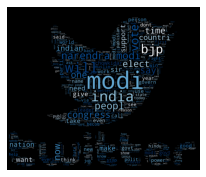

In [12]:
# If you want to visualize some shape like the on the top of the notebook 
# you will need a mask that has only two colors:
# preferbly black or white but it's important to be two if you don't want random noise in terms
# of words floating around your main figure. For the default option it works with anything as long
# as you have one colored background and different one colored figure.


# this is my mask
mask = np.array(Image.open("data/twitter_mask.png"))


# I will put this code into a function in case I want to use this type of
# visualization later when I perform TF-IDF or some other filter

def create_cloud_picture(review):
    plt.figure(figsize=[5, 3])
    plt.axis('off')
    plt.imshow(review)
    plt.show()

cloud = WordCloud(mask=mask, max_words=800, colormap='Blues', background_color='Black').generate_from_text(" ".join(data['review'][1000:2000]))
create_cloud_picture(cloud)

-----------------

The very first thing we need to do is to check the distribution of our target variable. With 80k observations and 3 classes we will most likely need to make stratification. 

In [13]:
distribution_of_values = data.groupby(by=['sentiment']).size()
distribution_of_values

sentiment
-1    17520
 0    26857
 1    35622
dtype: int64

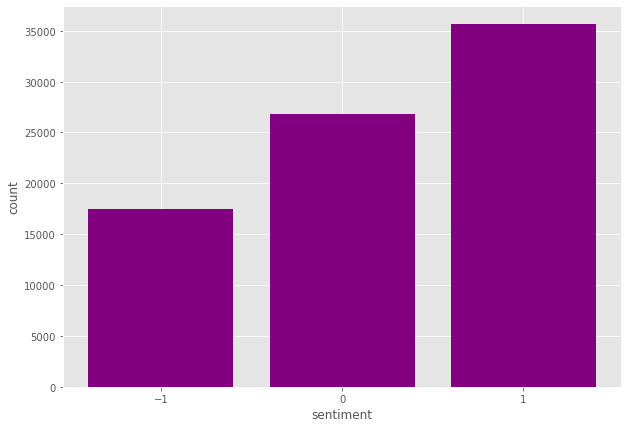

In [14]:
plt.figure(figsize=[10,7])
plt.bar(distribution_of_values.index, distribution_of_values, color = 'purple')
plt.xlabel('sentiment')
plt.xticks([-1, 0, 1])
plt.ylabel('count')
plt.show()

This is not a surprise, its not very often the classes to have equal representation in NLP. Not only do we need to use stratification but we might face the risk of our model evaluating and returning very good 'accuracy' only because it's predicting one class.

So there are few things we can do here:

- Obviously we dont take the 'accuracy' as the only reliable metric. We will use it but the main focus will be on confusion matrices, displaying precision, recall, f1, maybe ROC curves and some other metrics. Anyway, the distribution could definitely be worse so accuracy is still in the game.


- I believe more drastic measures like resampling the data(oversample the less presented class, undersample the big class or even generating artificially) are not required for the moment.


Let's make a pie chart and take a look, it should be better than looking at the numbers.

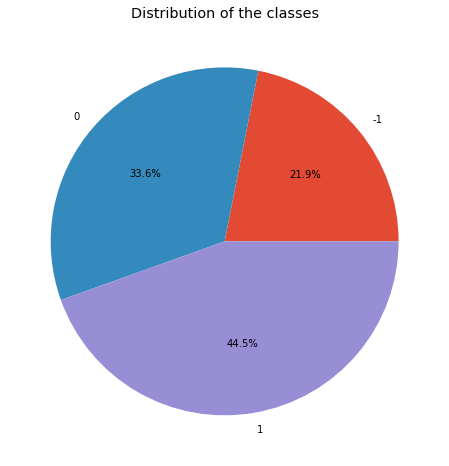

In [15]:
def make_pie_chart(data):
    plt.figure(figsize=[10,8])
    plt.pie(data, labels = [-1, 0, 1],  autopct='%1.1f%%')
    plt.title("Distribution of the classes")
    plt.show()

make_pie_chart(distribution_of_values)

We will obviously stratify by the labels but anyway it's not too bad. In the two-way  and more-way classifications like reviews or ratings the distribution is usually really bad. We can live with what've got here, we don't have to change anything for now.


## Extracting features from text (with explanation)


Back to processing. We still haven't prepared our raw text data. We need to turn our reviews from text/words to numbers or more precisely to numerical feature vectors. Luckily Scikit-learn makes this process very easy and friendly. Here is how it goes.

We will be using a model called "Bag of words".It basically returns the occurences of each word in a sentence, document or in our case - comment. Let's have a real example with our own data:


In [16]:
# I will use this code more than once so let's wrap it in a function.
# Let's create a bag of words with few comments until we get to know it well
# and make sure ourselves we are doing it properly

def generate_matrices(chosen_range):
    c = [data['review'][x] for x in range(chosen_range)]
    # parameter stop words is used in NLP to remove the most common words like 'the', 'is' etc..
    test = CountVectorizer(stop_words='english')
    result = test.fit_transform(c)
    return test, result

# Here we are using the first two comments of our dataset.

matrix_for_2_comments = generate_matrices(2)

In [17]:
# Let's visualize what we have now

count_vect_df = pd.DataFrame(matrix_for_2_comments[1].todense(), columns=matrix_for_2_comments[0].get_feature_names())
count_vect_df

begin  busi  continu  difficult  does  drama  exit  expect  govern  job  \
0      1     1        0          1     1      0     1       1       2    1   
1      0     0        1          0     0      1     0       0       0    0   

   ...  modi  nonsens  promis  psus  reform  state  talk  templ  vote  year  
0  ...     1        0       1     1       1      2     0      1     0     1  
1  ...     1        1       0     0       0      0     1      0     1     0  

[2 rows x 23 columns]

On each row we've got the occurences of each word in the **comment**! The length of the row depends on the unique words in the **series**. Remember the stemming?  

Now starting to understand the "Bag of words"? 'drama' occured in the second comment once and it didn't in the first. 'begin', 'busi', 'difficult'... are not presented in the second comment. We notice that the first comment is much longer than the second one but despite that the occurences of all the words of the first comment(without the stop words of course) are recorded in the second one as 0!  And vice versa! There are no NaNs or invalid values. If we add more comments, as we will, the number of columns will increase for every unique, new word.You can see now the significance of stemming.  
 
At the very beginning this process should increase the columns rapidly but at the end, when most of the words are already used, it shoold 'cool off' a bit. This is a good way to get familiar with the nicely provided by scikit learn library algorithms but we need to understand how they work and what they return. It is also a good form of debugging, which is much harder in Machine Learning than in Software development. So let's test this logical assumption.

In [18]:
# Doing absolutely the same as before, just working with more comments to verify my hypothesis.

matrix_for_10_comments = generate_matrices(10)[1].shape
matrix_for_50_comments = generate_matrices(50)[1].shape
matrix_for_200_comments = generate_matrices(200)[1].shape
matrix_for_1000_comments = generate_matrices(1000)[1].shape
matrix_for_3000_comments = generate_matrices(3000)[1].shape

d = {'comments': [matrix_for_10_comments[0], matrix_for_50_comments[0], matrix_for_200_comments[0], 
                 matrix_for_1000_comments[0], matrix_for_3000_comments[0]],
    'unique_words': [matrix_for_10_comments[1], matrix_for_50_comments[1], matrix_for_200_comments[1], 
                 matrix_for_1000_comments[1], matrix_for_3000_comments[1]]}

test_data = pd.DataFrame(data=d)


In [19]:
# Here we will use plotly because for the first two groups is close to impossible
# to see the values so the plotly's interactivity might be in great help.
# You can draw squares with the points that you want zoomed. Double click to return

fig = go.Figure(data=[
    go.Bar(name='Comments', y=test_data['comments']),
    go.Bar(name='Unique Words', y=test_data['unique_words'])
])
fig.update_layout( barmode='group', title = "Comments-Unique Words ratio")
fig.update_xaxes(title_text = 'ratio')
fig.update_yaxes(title_text = 'count')
fig.show()

Just as expected. The red bars would have been higher without stemming. Lemmatizing would have reduced much less and with the original data it would have been nightmare with the dimensions.

Speaking of dimensions... now that we understand what Bag of words and CountVectorizers are we can modify our entire set. What we did so far unfortunatelly is not enough to feed our models.



Now we will use a statistic called TF-IDF. It stands for Term Frequency — Inverse Document Frequency. The whole idea is to assess how important one word is while also taking into consideration its relation to the other comments.

The general formula is:

$$tfidf(t, d, D) = tf(t, d) * idf(t, D)$$

This obviously looks horrible to comprehend so let's split it to its components in order to understand better:

tf_idf is a score where 't' is 'term', 'd' is document and 'D' is the collection of all the documents. Basically we've got two different formulas combined into one.

TF is very simple as well as its calculation. It's the number of times a particular word occurs in the particular text divided by the total number of words in the text.

IDF is a bit more complicated but it basically measures how important a word is. The mathematical formula is:

$$ log(\frac {n} {df(t) +1})$$

where n is the total number of documents in the document set and df(t) is the document frequency of t.

You can learn more about it from the docs of sklearn about TfIDFTransformer [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

-----------------------------------------------------------------------------------------------------------------------------
We already rigorously inspected the CountVectorizer, the tfIdfTransformer is basically an application of the TF-IDF statistics we've been talking about so far.

Instead of applying it one by one we could also use sklearn's TfidfVectorizer which is doing the two opperations at once in a faster, more optimized and readable way.

In [20]:
# tf_idf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english') )
# processed_data = tf_idf_vectorizer.fit_transform(data['review'])
# processed_data.shape

## Dimensionality reduction



(79999, 50503) 

We've got our matrix of processed features - 79999 rows/observations, 50503 colums/features. It's also known as sparse matrix - most of the values in it are zeros. 

But often we cannot work with that many dimensions. Imagine the time to perform hyperparameters tuning and even training for some slow algorithms like SVMs or Boosting models - it takes too long.

In Machine Learning dimensionality reduction is known with its valuable preprocessing advantages. It is also a ML model but not a model for training and predicting but for finding the important features that bring most of the valuable information via standard linear algebra operation with matrices. Let's apply it since we are desperately seeking for reduction. 

PCA is the most famous model for dimensionality reduction but its not an appropriate one for this job. We'll be using TruncatedSVD which is the recommended one by the official documentation page of the PCA for sparse matrices. Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means it can work with sparse matrices efficiently.

In [21]:
# svd = TruncatedSVD(n_components = 5000, n_iter = 1000)
# transformed = svd.fit_transform(processed_data)
# cumulative_sum = np.sum(svd.explained_variance_ratio_)
# cumulative_sum

For the sake of your machines I'll comment the demanding operations and report the results. With applying SVD over our data with 5000 features we were able to retrieve $\approx$ 96% variance or valuable information. So this means despite our cleaning, stemming and processing we had about 45k useless features/words. Just pause for a second and think without stemming and preprocessing.

We could use TruncatedSVD to get these features but with TF-IDF Vectorizer and parameter max_features set to the number we received from SVD model it's faster. It only works because it applies TF-IDF and returns **n** best features ordered by term frequency across the corpus.

In [22]:
tf_idf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), max_features=5000 )
processed_data = tf_idf_vectorizer.fit_transform(data['review'])
processed_data.shape

(79999, 5000)

Now we have reduced our original training data more than 10 times. The original 'processed' dataset returned more than 100k features after TF-IDF Vectorizer. With Lemmatizing it returned about 80k, with cleaning the tweets, Stemming and some Regex operations as we saw we reduced it to 50k and now with STD we 'only' have 5000 columns. 

In terms of dimensionality reduction operation Sentiment Analysis tasks are among the worst to perform it on but at least the TF-IDF operation normalizes and scales the data so we don't need to do that manually. In the science the most appreciated idea is to leave the transformers as they are. More about the topic [right here](https://freakonometrics.hypotheses.org/53470).

In [23]:
print(processed_data.min())
print(processed_data.max())

0.0
1.0


Everything is alright so we move on.

## Visualization in lower dimensions

This is the final section of our preprocessing and EDA journey.

There are many algorithms including t-SNE, Isomap etc that are used very often in image and text processing for visualizations. They are very helpful tools especially when working with more than 2 labels in more dimensions. [Read more here](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). 

Since we are working with a lot of columns in a sparse matrix that is already scaled it would be smart to stick to the TruncatedSVD instead of repeating the same processes again for t-SNE. This would be a very silly thing to do.

In [24]:
sample_x = processed_data[:5000]
sample_y = data['sentiment'][:5000]

5000 points should be more than enough.Let's turn them into strings for better and cleaner visualization.

In [25]:
sample_y = sample_y.replace(-1, 'negative')
sample_y = sample_y.replace(0, 'neutral')
sample_y = sample_y.replace(1, 'positive')

In [26]:
data['sentiment'][:5000].value_counts()

 1    2119
 0    1793
-1    1088
Name: sentiment, dtype: int64

This is not a terrible representation.We can move on with our idea.

In [27]:
reductor = TruncatedSVD(n_components=3)

In [28]:
three_dimensional_perspective = reductor.fit_transform(sample_x.toarray())

In [29]:
fig = px.scatter_3d( x=three_dimensional_perspective[:, 0], y=three_dimensional_perspective[:, 1],
                    z=three_dimensional_perspective[:, 2],
              color=sample_y, title="3d representation of the data")
fig.show()

Hmm, this was not completely useless. Few things that you might notice if you play with the 'camera' a little. The form reminds a lot of a parabola. The density of the positive class should suggest that this is going to be easy class to predict. There isn't one big cluster, but they are few and they are thick. The standard deviation of the neutral is the highest by far but it also creates sort of a parabola with its own values. The negative class forms no clusters, it's variance is also big but unlike the neutral it doesn't look like anything that is easily explicable. So this class is probably going to be the toughest one to predict.

## Models

### Strategy 

In order to find the best model that suits our data and its specifics we first need to understand the simpler models, their strengths and weakness. Then we can move on to some boosting/ensembling techniques or even to models that go deeper in the dimensions. At the end we will compare our models in terms of metrics like accuracy, f1, confusion matrices, time to tune and time to perform etc. We will choose one or some of the best and think of a way to improve them even more.

------------------------------

Since we are trying to solve a classification problem we cannot not start with the classics in NLP - Naive Bayes. First We need to prepare the data for training, testing and validation.

We will use Cross Validation with k = 5 to be precise for all our models from now on and instead of fitting, predicting and then getting results one line by one, we will use the functions 'cross_validate' and 'cross_validate_predict' to evaluate in tidier fashion.

**Note!!! You might say this is just repeating the entire cross validation process and you are correct. It is repeating and it will take time. But... 'cross_validate_score' does not support adding multiple metrics to it. And we want to see all the accuracy, f1, recall and precision scores. From the other hand with only 'cross_validate' we cannot predict and see on which class we are doing good and on which class we are doig bad. So yes, it's a bit tedious, but this is the correct and the ultimate way to get the most objective motion of the model's performance.**


In [30]:
x_train, x_test, y_train, y_test = train_test_split(processed_data, data['sentiment'],
                                                                        test_size = 0.2, 
                                                                        stratify = data['sentiment'])

From now on we use x_train and y_train on our cross validations for each algorithm. At the end when we see how they did we will pick one or few of the best models to:

1) train/fit the models

2) make a final test with the data on this file

3) put them on a Pipeline and pickle/save them (more about this process at the end of the notebook)

4) load and test them in new notebook and environment on the other 80+k observations of the original dataset.

### Tuning

For each Random/Grid search we perform from now on we will use
the parameters cv = k_fold which is to cross validate on 5 different set,
verbose = 0 not to spam many messages and n_jobs = -1 
to use all the CPUs on our machine


In [31]:
k_fold = StratifiedKFold(n_splits=5, shuffle = True)


-------------------------------------------------

When modelling you can't simply put random numbers for hyperparameters or go with the default one. Not if you are trying to achieve good results, of course. We need to test many combination and the process is long and tedious but it is an absolute must in any serious Machine Learning research.

There are several options, most popular are the GridSearch and RandomSearch. GridSearch is Brute Force algorithm that will test every hyperparameter combination possible. RandmSearch will combine randomly.[This article](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85) gives a nice in-depth explanation about the strenghts and disadvantages of each algorithm, we'll use the RandomizedSearchCV where our machine cannot handle the search, and Grid where it can.

I will run it once, get the parameters, comment it and hard code them to the models to spare you time. 

Usually when looking for the best algorithm between many some of them will return very close results. So it's a good practice to measure how long every single one of them took.

### Naive Bayes

----------------------------------------------------------------------------------------------------------------

This algorithm follows the Bayes theorem which is:

$$P(H | E) = \frac {P(E | H)} {P(E)} * P(H)$$

These algorithms rely on Bayes's theorem, which is an equation describing the relationship of conditional probabilities of statistical quantities. In Bayesian classification, we're interested in finding the probability of a label given some observed features, which we can write as P(L | features). Bayes's theorem tells us how to express this in terms of quantities we can compute more directly. 

It's essence, implementation and usage with sklearn are beatufilly explained by Jake Van Der Plas [here](https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html).

We'll be using Complement NB which is typical NB algorithm but it was designed to correct some of the 'naive assumption' of the standard Multinomial NB. It's very good on huge, unbalanced data like ours. More about it [right here](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.ComplementNB.html#sklearn.naive_bayes.ComplementNB).


In [32]:
# params = {'alpha':[1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 1e2, 1e4, 1e6, 1e9]}
# rs = GridSearchCV(ComplementNB(), param_grid=params, scoring='f1_macro', cv=k_fold, verbose=0, n_jobs=-1)
# start = time.time()
# rs.fit(x_train, y_train)
# end = time.time()
# tuning_nb = end - start
tuning_nb = 0.7428932189941406



That was so fast that I start to wonder why we even commented. But you will see that's not the case with the other algorithms.

Now let's start applying our strategy.

In [33]:
# Fit with the tuned hyperparameters
naive_bayes = ComplementNB(alpha = 1, fit_prior=True, class_prior=None)


In [34]:
# Check the metrics
start = time.time()
scores = cross_validate(naive_bayes, x_train, y_train, cv = k_fold, n_jobs=-1, verbose=0,
                       scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])
end = time.time()
training_nb = end - start
nb_scores = scores
scores

{'fit_time': array([0.02074146, 0.03570819, 0.02601957, 0.02659535, 0.01926327]),
 'score_time': array([0.01568794, 0.03900433, 0.01711082, 0.01686025, 0.03217006]),
 'test_accuracy': array([0.71992188, 0.71625   , 0.71882813, 0.723125  , 0.72029065]),
 'test_f1_macro': array([0.71003464, 0.70706854, 0.70929779, 0.71341962, 0.70930202]),
 'test_precision_macro': array([0.70639473, 0.70299762, 0.70537876, 0.70941344, 0.70591469]),
 'test_recall_macro': array([0.7216492 , 0.71672024, 0.718984  , 0.72426284, 0.71959065])}

In [35]:
cros_val_score = cross_val_predict(naive_bayes, x_train, y_train, n_jobs=-1, cv=5, verbose = 0)

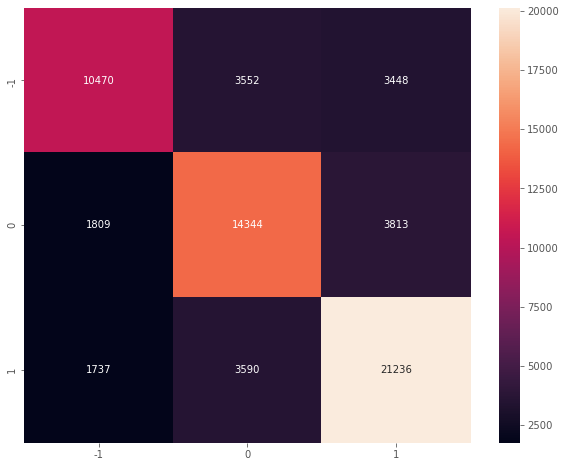

In [36]:
# see how it did on particular classes
conf_mat_nb = confusion_matrix(cros_val_score, y_train)
plt.figure(figsize=[10,8])
sns.heatmap(conf_mat_nb, annot= True, robust = True, fmt='g', xticklabels=range(-1,2), yticklabels=range(-1,2))
plt.show()

There are many ways to interpret this matrix. I use the primary diagonal rule. The correct values are there, for example on position (0, 0) are the correct values of the first, negative class, (1,1) is for the second, neutral class, (2, 2) - for the third, positive class etc. The other values are the wrongly classified and you can use the rows to see to what class they've been assigned wrongly.

For example let's have a look at class 1 or positive comments. $\approx$ 21000 on position (2,2) have been correctly assigned as positives, $\approx$ between 3500-4000 of each have been mistaken for neutrals and negatives. This is a recall and it's been calculated by finding the % of the correct values divided by the correct + incorrect values on the **column**. The precision is very similar but it works with **rows** where we have true positives and false positives.

Those are good but not great results. It confuses neutrals a lot. The recall for neutrals is much smaller. There is only huge plus tho - As we could see Naive Bayes is super fast, it doesn't require the tedious hyperparameters tuning and after all it returned almost 72% accuracy and $\approx$ same on the other metrics. Not terrible start for less than a minute spent in tuning, training and scoring with cross validation.

### Logistic regression

Logistic regression is the first algorithm that uses Gradient descent that we will try here.

In [37]:

# params = {
#     "C": [1e-2, 1e-1,1e0, 1e1, 1e2, 1e3, 1e6, 1e9],
#     'max_iter': [10, 100, 1000],
#     'fit_intercept': [True, False]
# }
# random_search = GridSearchCV(LogisticRegression(),param_grid=params, scoring='f1_macro', cv=k_fold, verbose=0, n_jobs=-1)

# start = time.time()
# random_search.fit(x_train, y_train)
# end = time.time()
# tuning_log_reg_time = end - start
tuning_log_reg_time = 311.092511177063



Unfortunately Naive Bayes is one of a kind in terms of speed. Let's see if we can get some compensation for the time.

In [38]:
# we give our model the tuned hyperparameters

log_reg = LogisticRegression(C=10, max_iter=100, 
                             fit_intercept=True, class_weight='balanced')


In [39]:
# training and validating on the train data
start = time.time()
scores = cross_validate(log_reg, x_train, y_train, cv = k_fold, n_jobs=-1, verbose=0,
                       scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])
end = time.time()
training_log_reg_time = end - start
scores

{'fit_time': array([3.61282492, 3.26874995, 3.17145562, 3.26827693, 2.19064617]),
 'score_time': array([0.01552463, 0.0265801 , 0.01998639, 0.02862549, 0.01430249]),
 'test_accuracy': array([0.83804687, 0.83507813, 0.83304687, 0.82984375, 0.83459645]),
 'test_f1_macro': array([0.82972583, 0.8249836 , 0.82312632, 0.8200877 , 0.82482166]),
 'test_precision_macro': array([0.82514348, 0.82096476, 0.8198301 , 0.81623807, 0.82119017]),
 'test_recall_macro': array([0.83755321, 0.83224014, 0.82927226, 0.82715487, 0.83130256])}

In [40]:
log_reg_scores = scores

In [41]:
cros_val_score = cross_val_predict(log_reg, x_train, y_train, n_jobs=-1, cv=5, verbose = 0)

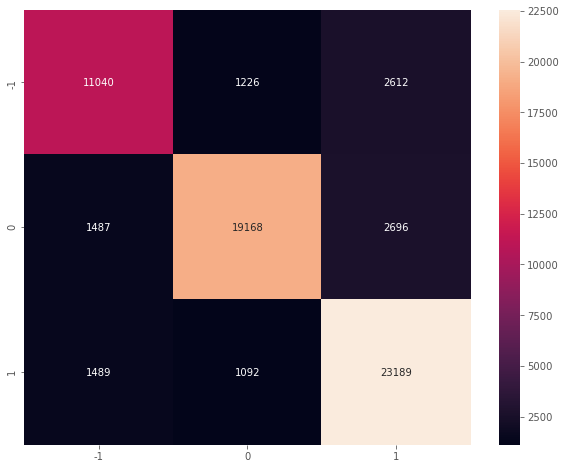

In [42]:
conf_mat_log_reg = confusion_matrix(cros_val_score, y_train)
plt.figure(figsize=[10,8])
sns.heatmap(conf_mat_log_reg, annot= True, robust = True, fmt='g', xticklabels=range(-1,2), yticklabels=range(-1,2))
plt.show()

Hmm, the model did much better than the Naive Bayes. It easily separated the neutrals class with recall of around 90%. A bit worse results with the positive class and even better  at negative class with recall of about 78%. But  78% recall to be your worst result for the least populated class - this is a success compared to NB.


### Decision trees


This is a very famous and quick algorithm based on if-else conditions and [information gain](http://www.saedsayad.com/decision_tree.htm). Since they are super fast and they depend solely on the maximum depth(the number of if-else conditions) we will try manually few of them with different depths.

##### Stump = depth 1

In [43]:
decision_stump = DecisionTreeClassifier(max_depth = 1)

In [44]:
scores = cross_validate(decision_stump, x_train, y_train, cv = k_fold, n_jobs=-1, verbose=0,
                       scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])
scores

{'fit_time': array([0.11623716, 0.13011646, 0.10407877, 0.1214211 , 0.09724808]),
 'score_time': array([0.01657701, 0.02032471, 0.01670098, 0.01512647, 0.01445985]),
 'test_accuracy': array([0.48015625, 0.48007813, 0.47507813, 0.47632812, 0.47659973]),
 'test_f1_macro': array([0.35798573, 0.35825648, 0.35421655, 0.35534887, 0.35579861]),
 'test_precision_macro': array([0.31840012, 0.31859965, 0.31507201, 0.31605573, 0.31638053]),
 'test_recall_macro': array([0.40930583, 0.40997484, 0.4048001 , 0.40671682, 0.40711148])}

This is not bad. If you are wondering what I'm talking about and why I even displayed this - well, we will use some ensembling and boosting algorithms that will have in their core the so-called decision stumps. I will explain down there why is it important to have week stumps.

##### Depth 200


In [45]:
depth_200 = DecisionTreeClassifier(max_depth = 200)
start = time.time()
scores = cross_validate(depth_200, x_train, y_train, cv = k_fold, n_jobs=-1, verbose=0,
                       scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])
end = time.time()
training_tree_time = end - start
scores

{'fit_time': array([15.2005055 , 15.36656284, 16.07087302, 15.73165202, 12.99659395]),
 'score_time': array([0.02218723, 0.02045846, 0.02366018, 0.03484464, 0.01847768]),
 'test_accuracy': array([0.765625  , 0.77179688, 0.75914063, 0.77007812, 0.7699039 ]),
 'test_f1_macro': array([0.74479963, 0.7500225 , 0.73612083, 0.74801813, 0.74692711]),
 'test_precision_macro': array([0.74902378, 0.75743804, 0.74221942, 0.75336817, 0.75417785]),
 'test_recall_macro': array([0.74594881, 0.74921748, 0.73587517, 0.74837303, 0.74654477])}

In [46]:
tree_scores = scores

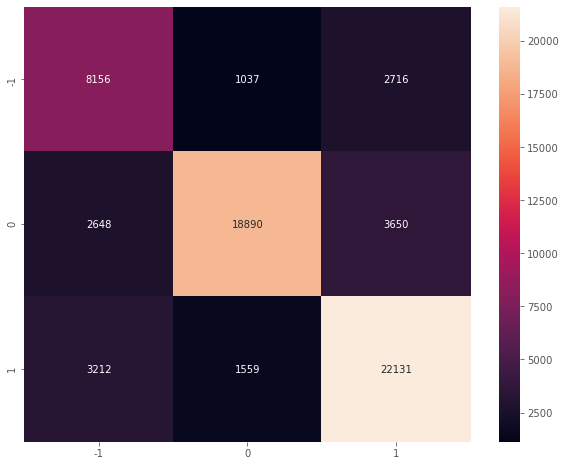

In [47]:
cros_val_score = cross_val_predict(depth_200, x_train, y_train, n_jobs=-1, cv=5, verbose = 0)
conf_mat_tree = confusion_matrix(cros_val_score, y_train)
plt.figure(figsize=[10,8])
sns.heatmap(conf_mat_tree, annot= True, robust = True, fmt='g', xticklabels=range(-1,2), yticklabels=range(-1,2))
plt.show()

At some point we hit the depth at that we are not achieving anything with a single tree within the reasonable. But clearly from the matrix we can see that it struggles the most with the negative comments.

Anyway single trees use to overfit training set big time if we use big maximum depth. That's why these structures are often used in Ensemble and Boosting algorithms as weak learners with low depth.

We will later try some Ensemble and Boosting algorithms later.

### Linear SVM

Support Vectors Classifiers are a must try in almost any classification problem. They try to find the best hyperplane to separate the different classes by maximizing the distance between sample points and the hyperplane.

You can approach any problem mainly by controlling the kernel. The most popular and used are linear and rbf kernels. 

We are going to use Linear SVM to begin with and see how it goes. Reason? - mainly because its faster. Much, much faster than the other SVM with different kernel tricks.

In [48]:
# params = {'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 'fit_intercept':[True, False]}
# start = time.time()
# rs = RandomizedSearchCV(LinearSVC(), param_distributions=params, scoring='f1_macro', cv = k_fold, verbose=0, n_jobs=-1)
# rs.fit(x_train, y_train)
# end = time.time()
# tuning_linear_svm = end - start
tuning_linear_svm = 194.3722414970398



In [49]:
linear_svm = LinearSVC( C = 100, fit_intercept = True, max_iter=2000, class_weight='balanced' )

In [50]:
start = time.time()
scores = cross_validate(linear_svm, x_train, y_train, cv = k_fold, n_jobs=-1, verbose=0,
                       scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

end = time.time()
training_svm_time = end - start
training_svm_time

104.31583881378174

In [51]:
scores

{'fit_time': array([72.22808933, 71.21970034, 72.7839241 , 69.27188921, 34.81485748]),
 'score_time': array([0.01580715, 0.01926041, 0.01532578, 0.01923585, 0.01447034]),
 'test_accuracy': array([0.8275    , 0.83328125, 0.83390625, 0.829375  , 0.82983046]),
 'test_f1_macro': array([0.81677542, 0.82256828, 0.82285525, 0.81747549, 0.81850613]),
 'test_precision_macro': array([0.81437811, 0.82060483, 0.82202536, 0.81654824, 0.81639266]),
 'test_recall_macro': array([0.82026086, 0.82547082, 0.82466941, 0.81960078, 0.82138944])}

In [52]:
linear_svm_scores = scores

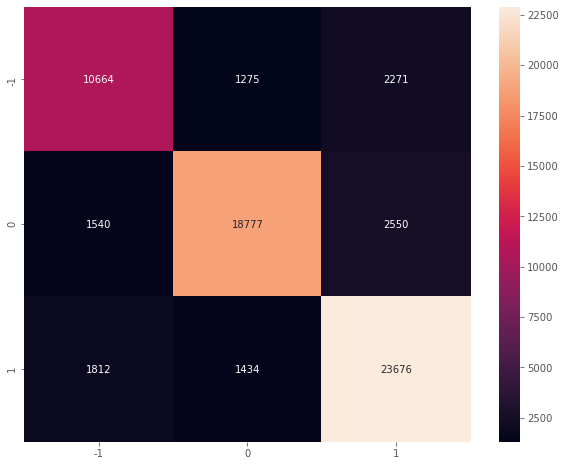

In [53]:
cros_val_score = cross_val_predict(linear_svm, x_train, y_train, n_jobs=-1, cv=5, verbose = 0)
conf_mat_svm = confusion_matrix(cros_val_score, y_train)
plt.figure(figsize=[10,8])
sns.heatmap(conf_mat_svm, annot= True, robust = True, fmt='g', xticklabels=range(-1,2), yticklabels=range(-1,2))
plt.show()

Compared to the Logistic Regression - very similar results generally. This is not a surprise - the both linearly separating the classes the way we've implemented them here and they have similar strengths and weaknesses - one weakness to be precise - the recall for negative class is lower than the other two. But not by far.

Now that we tried different basic approaches with the Trees based on If-Else digging and Information Gain, pure statistical probabilistic model like Naive Bayes and Linear models like Linear SVM and Logistic Regression, it's time to try push these algorithms a little bit further with some Bagging techniques also known as Ensemble algorithms and see what happens.

### Random Forest

Random Forest is the most famous Bagging ensemble algorithm using many estimators/trees to make final decision.

In [54]:
# params = {'max_depth': [10, 50, 100, 200],
#           'n_estimators':[50, 100, 200, 500]
#          }

# start = time.time()
# rs = RandomizedSearchCV(RandomForestClassifier(), param_distributions=params, scoring='f1_macro', cv = k_fold, verbose=0, n_jobs=-1)
# rs.fit(x_train, y_train)
# end = time.time()
# tuning_rf = end-start
tuning_rf = 2694.3568359375970398


Hmmm, this tedious hyperparameters tuning took awhile and returned the deepest possible depth and the most possible estimators. This probably means we need more, but for the moment we try with what we've got and see what happens.

In [55]:
rf = RandomForestClassifier(n_estimators=500, max_depth=200)

In [56]:
start = time.time()
scores = cross_validate(rf, x_train, y_train, cv = k_fold, n_jobs=-1, verbose=0,
                       scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

end = time.time()
training_rf= end - start
training_rf

/home/vlado/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



579.257073879242

In [57]:
rf_scores = scores
rf_scores

{'fit_time': array([321.29615808, 314.0299952 , 326.30823374, 320.57449627,
        257.60166359]),
 'score_time': array([3.58453131, 3.51601386, 3.1332891 , 3.69681883, 2.94596982]),
 'test_accuracy': array([0.80070312, 0.800625  , 0.80398437, 0.806875  , 0.80787562]),
 'test_f1_macro': array([0.77485531, 0.77728805, 0.78252191, 0.78503852, 0.78717828]),
 'test_precision_macro': array([0.80759179, 0.80536096, 0.81170224, 0.81244053, 0.81355327]),
 'test_recall_macro': array([0.76559158, 0.76868157, 0.77323208, 0.77584735, 0.77818319])}

/home/vlado/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



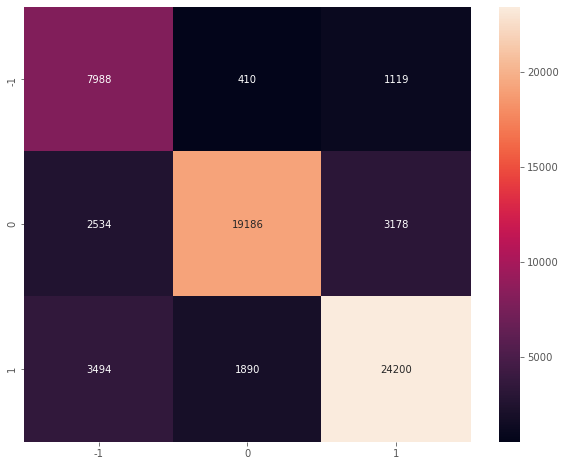

In [58]:
cros_val_score = cross_val_predict(rf, x_train, y_train, n_jobs=-1, cv=5, verbose = 0)
conf_mat_rf = confusion_matrix(cros_val_score, y_train)
plt.figure(figsize=[10,8])
sns.heatmap(conf_mat_rf, annot= True, robust = True, fmt='g', xticklabels=range(-1,2), yticklabels=range(-1,2))
plt.show()

Well, Random Forest did raise the metrics indeeed, we've got to give it that. Between 3-4% for all the metrics is not a slight improvement, it's a big one. But... it didn't give the Logistic Regression and Linear SVM scores as well... another but.. the tuning model returned the ultimate depth and n_estimators that we put in it. This means it can grow further but the cost of the training is too big in terms of memory and time. Let's keep that in mind and move on. This was definitely not our best try.

### Bagging Classifier SVM

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. 

This algorithm by default works with Random Trees but since we already tried them in Random Forest and they didn't do exceptionally better than the solo tree here it's time to try something new otherwise we will just waste our time. 

We'll use the default hyperparameter bootstrap = True which will make our samples to be drawn with replacement. By doing this we are performing 'bagging' in the true meaning of the word. More about this interesting ensembling [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html).

In [59]:
# params = {'base_estimator': [LinearSVC(), LogisticRegression()],
#                             'n_estimators':[50, 100, 200, 500]
#          }

# start = time.time()
# rs = RandomizedSearchCV(BaggingClassifier(), param_distributions=params, scoring='f1_macro', cv = k_fold, verbose=0, n_jobs=-1)
# rs.fit(x_train, y_train)
# end = time.time()
# tuning_bag = end-start
tuning_bag = 1473.0398359375970375

In [60]:
bag_svm = BaggingClassifier( LinearSVC(), n_estimators = 50)

In [61]:
start = time.time()
scores = cross_validate(bag_svm, x_train, y_train, cv = k_fold, n_jobs=-1, verbose=0,
                       scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

end = time.time()
training_bag = end - start
training_bag

273.62338852882385

In [62]:
bag_scores = scores
scores

{'fit_time': array([174.39278555, 178.35138106, 184.22112179, 174.44613576,
         97.5567565 ]),
 'score_time': array([0.84625578, 0.81689334, 0.68208814, 0.78570819, 0.68753409]),
 'test_accuracy': array([0.8453125 , 0.8371875 , 0.84390625, 0.84585937, 0.8422533 ]),
 'test_f1_macro': array([0.83370298, 0.82352384, 0.83117502, 0.83390039, 0.83041537]),
 'test_precision_macro': array([0.83831045, 0.83101403, 0.83566975, 0.83999656, 0.83537626]),
 'test_recall_macro': array([0.8316691 , 0.82001335, 0.82893304, 0.8309574 , 0.82825944])}

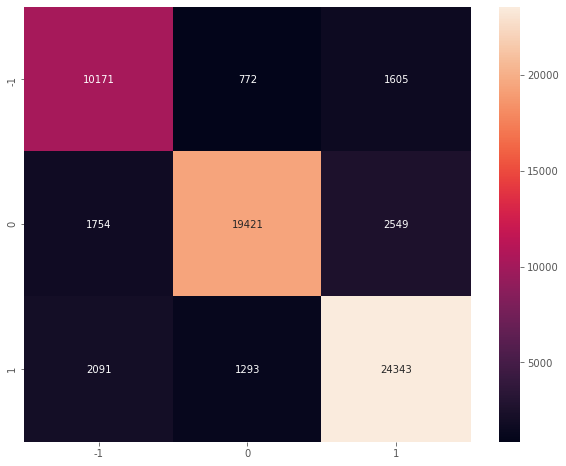

In [63]:
cros_val_score = cross_val_predict(bag_svm, x_train, y_train, n_jobs=-1, cv=5, verbose = 0)
conf_mat_bag = confusion_matrix(cros_val_score, y_train)
plt.figure(figsize=[10,8])
sns.heatmap(conf_mat_bag, annot= True, robust = True, fmt='g', xticklabels=range(-1,2), yticklabels=range(-1,2))
plt.show()

So unlike Random Forest here we didn't receive the biggest n_estimators values so in this way, with these base estimators it's pointless to continue raising them.

Aparently we are drawing the best possible separating the classes planes with our logistic regression and linear SVM. Actually let's stop for a moment, visualize what we achieved, analyze it and decide what to do next.

## Models Assessment

We will use plotly because it easily provides nice interactive subplots on which we could see the performances of each model we measured so far. In order to keep it clean, let's make a dataframe with the scores.

In [64]:
# here I'm just creating the matrix, getting the time it took 
# to train and tune and the mean of each cv score list that we received

nb = ['Naive Bayes', tuning_nb, training_nb, nb_scores['test_accuracy'].mean() * 100, nb_scores['test_f1_macro'].mean() * 100, nb_scores['test_precision_macro'].mean() * 100, nb_scores['test_recall_macro'].mean() * 100]
lr = ['Logistic Reg', round(tuning_log_reg_time), round(training_log_reg_time), log_reg_scores['test_accuracy'].mean() * 100, log_reg_scores['test_f1_macro'].mean()* 100, log_reg_scores['test_precision_macro'].mean()* 100, log_reg_scores['test_recall_macro'].mean()* 100]
tree = ['Tree', 0, round(training_tree_time), tree_scores['test_accuracy'].mean()* 100, tree_scores['test_f1_macro'].mean()* 100, tree_scores['test_precision_macro'].mean()* 100, tree_scores['test_recall_macro'].mean()* 100]
lsvm = ['Linear SVM', round(tuning_linear_svm), round(training_svm_time), linear_svm_scores['test_accuracy'].mean()* 100, linear_svm_scores['test_f1_macro'].mean()* 100, linear_svm_scores['test_precision_macro'].mean()* 100, linear_svm_scores['test_recall_macro'].mean()* 100]
bag = ['Bag Classifier', round(tuning_bag), round(training_bag), bag_scores['test_accuracy'].mean()* 100, bag_scores['test_f1_macro'].mean()* 100, bag_scores['test_precision_macro'].mean()* 100, bag_scores['test_recall_macro'].mean()* 100]
rfor = ['Random Forest', round(tuning_rf), round(training_rf), rf_scores['test_accuracy'].mean()* 100, rf_scores['test_f1_macro'].mean()* 100, rf_scores['test_precision_macro'].mean()* 100, rf_scores['test_recall_macro'].mean()* 100]
df_scores = pd.DataFrame([nb, lr, tree, lsvm, bag, rfor],
                         columns=['name', "tuning_time","training_time", "accuracy", "f1", 'precision', 'recall'])


Good this is much cleaner. Now let's visualize.

In [65]:
fig = make_subplots(rows=3, cols=2, subplot_titles=("Tuning Time in seconds","Training Time in seconds", "Accuracy %", 'F1 %', "Precision %", 'Recall %'))



fig.add_trace(go.Bar(x=df_scores['tuning_time'], y=df_scores['name'], orientation='h'),
                 row=1, col=1)


fig.add_trace(go.Bar(x=df_scores['training_time'], y=df_scores['name'], orientation='h'),
                 row=1, col=2)


fig.add_trace(go.Bar(x=df_scores['name'], y=df_scores['accuracy'], orientation='v'),
                 row=2, col=1)

fig.add_trace(go.Bar(x=df_scores['name'], y=df_scores['f1'], orientation='v'),
                 row=2, col=2)

fig.add_trace(go.Bar(x=df_scores['name'], y=df_scores['precision'], orientation='v'),
                 row=3, col=1)

fig.add_trace(go.Bar(x=df_scores['name'], y=df_scores['recall'], orientation='v'),
                 row=3, col=2)

fig.update_layout(height=1450, width=900, title_text="Models performance Dashboard", showlegend = False)

fig.show()




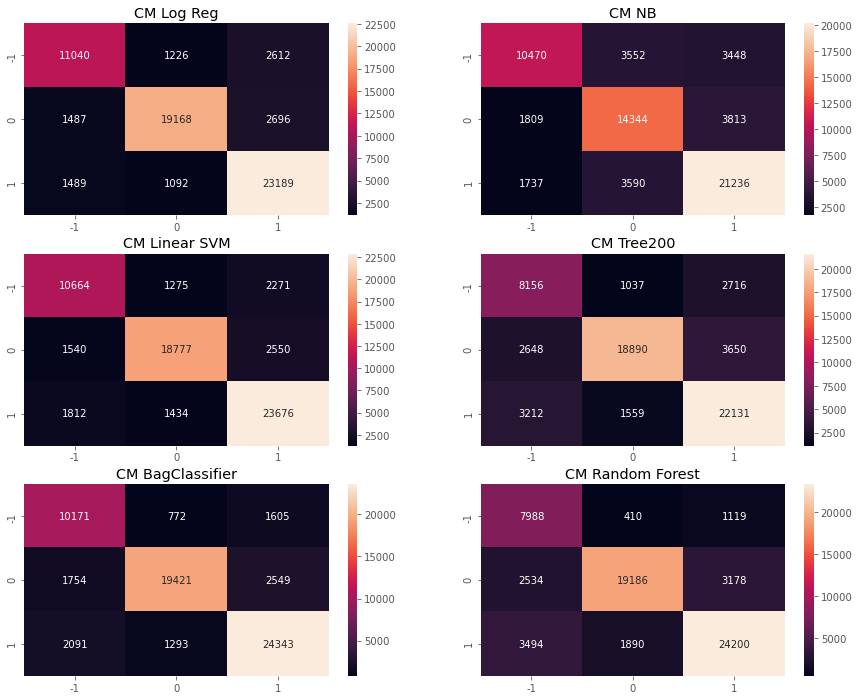

In [66]:
fig, ax = plt.subplots(3,2)
fig.set_figheight(12)
fig.set_figwidth(15)
sns.heatmap(conf_mat_log_reg, annot= True, robust = True, fmt='g', xticklabels=range(-1,2), yticklabels=range(-1,2), ax=ax[0, 0])
ax[0, 0].set_title('CM Log Reg')
sns.heatmap(conf_mat_nb, annot= True, robust = True, fmt='g', xticklabels=range(-1,2), yticklabels=range(-1,2), ax=ax[0,1])
ax[0, 1].set_title('CM NB')
sns.heatmap(conf_mat_svm, annot= True, robust = True, fmt='g', xticklabels=range(-1,2), yticklabels=range(-1,2), ax=ax[1, 0])
ax[1, 0].set_title('CM Linear SVM')
sns.heatmap(conf_mat_tree, annot= True, robust = True, fmt='g', xticklabels=range(-1,2), yticklabels=range(-1,2), ax=ax[1, 1])
ax[1, 1].set_title('CM Tree200')
sns.heatmap(conf_mat_bag, annot= True, robust = True, fmt='g', xticklabels=range(-1,2), yticklabels=range(-1,2), ax=ax[2,0])
ax[2, 0].set_title('CM BagClassifier')
sns.heatmap(conf_mat_rf, annot= True, robust = True, fmt='g', xticklabels=range(-1,2), yticklabels=range(-1,2), ax=ax[2, 1])
ax[2, 1].set_title('CM Random Forest')
plt.show()

Now we can compare models easily without scrolling up and down.

Let's talk about it now. Apparently the dataset has linear relationship between to some big degree hence it's linearly separable in the dimensions we've made. The results we managed to achieve are not bad at all. We've got three very strong models in Linear SVM Bagging Classifier, Linear SVM and Logistic Regression that returned high accuracy and f1. Random Forest is slightly behind but it has one really big weakness - the recall for negative class is very low. Naive Bayes and Tree are not real contenders, they are much more biased and tree is probably going to start overfit the data hard at some point.

Unfortunatelly with the BaggingClassifier it took us too much time compared to the other two and it didn't return higher results. Yes, we raised our f1 and accuracy scores with roughly 1.5% but the saddest thing about it was the the tuning process. Unlike the Random Forest where we received after 45 minutes of tuning 'you can do more' here it's basically the same thing if we give him 50, 100 or 1000 estimators. So it's safe to conclude that with this linear approach and with these three models + Bagging we did all we could with the given hyperparameter tuning.

This pretty much sums up the big picture. Now let's focus on the details and confusion matrices. One quick look shows that the recall for the negative class is the worst for every class with the exception of NB where the recall for neutral class is worse. Unfortunatelly NB is in fact worse than all of the others models in general and the recall for the negative class despite being the second best among these by the skin of its teeth is still around 72%. Which is not good.

It's not good because we could have tried another great 'trick' in ML and this is giving weights and vote among particular models that are good at particular class. But this is pointless now because all of our good models are good at some things(class 1 and class 0) and bad at the same remaining thing(class -1).

Why is that? Is it because it's the least populated class? It's possible. Is it easily confused with one of the other classes in particular? Not really. It's slightly more often mistaken with the class 1 than class 0 but class 1 is also bigger than class 0 in terms of sample size. Is adding more data going to increase our scores on this particular class without damaging the other two? Most likely. Is oversampling or undersampling going to do the same thing? We don't know. We also haven't decided if we are happy with the results we've got. Some might say they are pretty good.

So instead of looking for something tedious like rbf or polynomial kernel trick or even getting polynomial features,  we will use them together in something called stacking.

Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

Here we'll stack Linear SVM, default Bagging Classifier which uses tree, NB and Tree and as final estimator we'll use Logistic Regression as our fastest and among the most reliable models.




### Stacking classifier

So I'll comment the cross validation process because it's rougly 20 minutes and only display the results I've achieved first time. Feel free to test the code, the results will be similar.

In [67]:
estimators = [('svm', LinearSVC()),('bag', BaggingClassifier()), ('nb', ComplementNB()),('tree', DecisionTreeClassifier()) ]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), verbose=0, n_jobs=-1)

In [68]:
# start = time.time()
# scores = cross_validate(clf, x_train, y_train, cv = k_fold, n_jobs=-1, verbose=0,
#                        scoring=['accuracy', 'f1_macro', 'precision_macro', 'recall_macro'])

# end = time.time()
# training_stack = end - start
# 
training_stack = 1284.8319466114044


In [69]:
# print(f"F1: {scores['test_f1_macro'].mean()}")
# print(f"accuracy: {scores['test_accuracy'].mean()}")
# print(f"precision: {scores['test_precision_macro'].mean()}")
# print(f"recall: {scores['test_recall_macro'].mean()}")

print('F1: 0.8407141789673924')
print('accuracy: 0.8512008848347528')
print('precision: 0.8442686382392675')
print('recall: 0.8374015991200603')

F1: 0.8407141789673924
accuracy: 0.8512008848347528
precision: 0.8442686382392675
recall: 0.8374015991200603


So we've managed to improve our f1 score to $\approx$ 84.5% and our accuracy over 85.5%. It took 20 minutes to verify that via double cross validation but for this large type of data we should be rather satisfied with our results. Now we've got one last thing to do - test our model on the data we've kept hidden all this time.

In [70]:
# Let's train it
clf.fit(x_train, y_train)

/home/vlado/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



StackingClassifier(estimators=[('svm', LinearSVC()),
                               ('bag', BaggingClassifier()),
                               ('nb', ComplementNB()),
                               ('tree', DecisionTreeClassifier())],
                   final_estimator=LogisticRegression(), n_jobs=-1)

In [71]:
# and let's check how it does on training and then finally on testing data
# clf.score(x_train, y_train)

In [72]:
clf.score(x_test, y_test)

0.8559375

In [73]:
f1_score(clf.predict(x_test), y_test, average='macro')

0.8453262652404231

## Conclusion

- We've managed to achieve over 85% accuracy and over 84% F1 score with a simple stacking model that is not taking a lot of time. The combined metric of precision and recall is important because our classes are not equally represented and we can't solely rely on the accuracy. The similar percentages are a good sign we are doing relatively well.


- We have simpler models in Linear SVC and Logistic Regression that are being executed super quickly and achieve our desired metrics only with $\approx$ 2-3% lower than the ensemble.


- We've managed to do point 1 relatively quickly. This is because we started with simple linear models and stick to them. There was no need, thankfully, to extract polynomial features or use different kernels for the SVMs. 


- Random Forest and different bagging and classifiers were not the stars of this show. They were slow but with the given time and resource, they could have gone further.


- The addition of the other half of the data did not improved the models(the expiriment was held off screen). But... the data distribution was still not equal. A good TODO and continuation of this work would be to add only negative classes to the original data to make the distribution more equal.


- About the missing percentages - we have $\approx$ 15% misclassified values and between 16-17% False positives and False negatives. Why did we not catch them? Firstly, we performed SVD and shrank the variance a little bit but that's probably not it. Second - the data. The noise is in it is too big. This is Twitter we are talking about. We tried everything we could to clean and preprocess the data but we can't think of any possible noise that can be generated out of the angry or overexcited supporter of the Indian Prime minister.If you perform tf-idf on the raw data and see the features, you will notice stuff like '0000000008888888', 'aaaaaaaaaa' etc popping up. We have to assume we couldn't filter it all. Also there are the problems with the sarcasm and irony, stimulus detection and many other problems with Natural Language processing that occur almost every time. But for the purpose of this research, to perform a classical Sentiment analysis we might conclude that we did well.


Could we go with SVM with different kernel? Sure. Is it possible to get polynomial features and train hard with Logistic Regression? Yes, it is. Is this going to increase the accuracy and f1 a bit? Probably. But this would totally break our ballance. Imagine the time to tune the hyperparameters for Gaussian SVM with 1 million features. Imagine performing cross validation twice, as we did with the models above. Is it going to be worth it for 2-3% increase in metrics? We cannot be sure it will give us more than that.


Now we've got one more thing to do to finish the cycle. Let's pick our models, and turn them into binary files so we could use it later without the need to wait the notebook to run all the cells again.

### Export the classifiers and reuse them in different environment with SKLearn Pipeline and Pickle


In Python the standard way for serializing objects is with Pickle. For more info about it -> [docs](https://docs.python.org/3/library/pickle.html). But we are not only fitting and scoring, we've got cleaning, stemming, tf idf transformation, cross validation etc. You don't want to present your algorithm in front of other people and make them wait while you are performing these steps. This is where pickle and scikit learn Pipeline come along.

Pipelines are very cool but every step has to look like a sklearn transformer. Basically this means that everything that goes into a pipeline has to implement fit or transform methods. That's why putting directly the Tf IDf vectorizer and our models to the Pipeline can be done immediately. But we don't want our colleagues or eventually users to have to clean and stem the data themselves. That's why we need to add to our Pipe our custom functions 'clean_text' that performs regular expressions and clean the junk out of the tweets and the 'stem_series" that performs the entire stemming process. So we need to make them 'transformers which can be done easily with [FunctionTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html).

I have already created three pickle files for Logistic Regression, Linear SVM and Ensemble, I'll comment the code here so we don't overwrite it each time we run the cells.

In [74]:
# from functions import custom_clean_transformer, custom_stem_transformer

In [75]:
# clean_transformer = FunctionTransformer(custom_clean_transformer)
# stem_transformer = FunctionTransformer(custom_stem_transformer)

In [76]:
# ensemble_pipeline = Pipeline([('clean', clean_transformer),('stemmer', stem_transformer),
#                                          ('vectorizer', tf_idf_vectorizer), ('classifier', clf)])

In [77]:
# ensemble_pipeline.fit(data['review'], data['sentiment'])

In [78]:
# import pickle

In [79]:
# save_classifier = open("ensemble.pickle","wb")
# pickle.dump(ensemble_pipeline, save_classifier)
# save_classifier.close()

Now you can go to [TESTS](2.TESTS.ipynb) file and before the Unit tests and the other boring stuff I've tried the serialized binary object directly, without transforming, vectorizing, splitting and fitting over the other 80000 reviews of the original dataset from kaggle that we left untouched. This is the final, ultimate test for our models - with data we have never even read, in different environment.

We now have reusable models.


## Todos

1) For those with limitless patience - polynomial features and different SVM kernels. More depth and n estimators on Random Forest. Deeper hyperparameters tuning on each model.


2) A little bit more humane decision - Neural Networks.


3) More feature engineering - adding more negative and neutral observations. Better cleaning and preprocessing - surely we haven't done that perfectly.

# Resources

1) Kaggle Dataset - https://www.kaggle.com/cosmos98/twitter-and-reddit-sentimental-analysis-dataset

2) Scikit Learn docs - https://scikit-learn.org/stable/index.html There is probably not a single cell without going for quick look to sklearn documentation.

3) Sentdex NLP tutorial with NLTK - https://pythonprogramming.net/tokenizing-words-sentences-nltk-tutorial/ - best for NLTK jobs

4) https://stackabuse.com/python-for-nlp-sentiment-analysis-with-scikit-learn/ - this tutorial helped me big time with the eda, processing and cleaning data 

5) [Link to test notebook](2.TESTS.ipynb) - testing the pickled model + unittests

6) [About Transformers scalling and why not to do it](https://freakonometrics.hypotheses.org/53470)

In [80]:
start = '22:41'
import datetime
datetime.datetime.now()

datetime.datetime(2020, 11, 3, 23, 23, 48, 210060)